# 2021 Steuerertrag

In [1]:
import pandas as pd
import numpy as np
import cleandata as cd
import matplotlib

In [2]:
df_raw = pd.read_csv('../data/Gemeinde_Exekutive - daten.csv')
df_bev_raw = pd.read_csv('../data/KANTON_ZUERICH_bevoelkerung_1jahresklassen.csv', sep=';')
df_steuern_raw = pd.read_csv('../data/steuerertrag_gemeinde.csv', sep=';')
df_gefis_raw = pd.read_csv('../data/gefis_bfs.csv', sep=';')

## Clean Data

In [3]:
df_raw = cd.clean(df_raw)

Jahrgänge nicht zugeordnet: 15
Partei nicht zugeordnet: 9
Keine Jahrgänge: 21


## Prepare Steuerdaten

In [4]:
df_gefis = df_gefis_raw[['GEFIS_EINHEIT', '2019']].copy()
df_gefis.rename(columns={'2019': 'bfs'}, inplace=True)

df_steuern = df_steuern_raw.merge(df_gefis, how='left', on = 'GEFIS_EINHEIT')

# Select with data
df_steuern = df_steuern.dropna(axis=0, subset=['2019'])

df_steuern = df_steuern[['bfs', 'GEBIETS_NAME', '2019']]

df_steuern = df_steuern.rename(columns={'2019': 'steuerertrag_2019'})

## Calc Gemeinden

In [5]:
def maxparty(row):
    maxi = 0
    maxs = ""
    multiple = False
    for i in row.index:
        if i in ['partei_c', 'Gemeinde', 'GEBIETS_NAME', 'bfs', 'steuerertrag_2019', 'total', 'parteilos%']: continue
        
        if row[i] == maxi:
            multiple = True
        elif row[i] > maxi:
            maxi = row[i]
            maxs = i
            multiple = False
            
    if multiple:
        return 'multiple'
    else:
        return maxs

In [6]:
df = pd.pivot_table(df_raw, index=['Gemeinde'], columns='partei_c', values='Name', aggfunc='count').copy().reset_index().fillna(0)
df = df.fillna(0)
df['total'] = df.sum(axis=1)
df['parteilos%'] = round(100 / df['total'] * df['parteilos'])

# Add BFS
df = cd.add_bfs(df)

# Join Steuerdaten
df = df.merge(df_steuern, how='left', on='bfs')

# Add Topparty
df['topparty'] = df.apply(maxparty, axis=1)

In [7]:
df.head()

,Gemeinde,al,bdp,cvp,edu,evp,fdp,glp,grüne,parteilos,sp,svp,vacant,verschiedene,total,parteilos%,bfs,GEBIETS_NAME,steuerertrag_2019,topparty
0,Adlikon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,5.0,60.0,21,"Adlikon, Politische Gemeinde",1619.0,parteilos
1,Adliswil,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,7.0,14.0,131,"Adliswil, Stadt",5841.0,fdp
2,Aesch (ZH),0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,5.0,20.0,241,"Aesch, Politische Gemeinde",1097.0,svp
3,Aeugst am Albis,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,8.0,25.0,1,"Aeugst a.A., Politische Gemeinde (bis 2020)",1702.0,multiple
4,Affoltern am Albis,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,7.0,29.0,2,"Affoltern a.A., Stadt",2368.0,multiple


<AxesSubplot:xlabel='parteilos%', ylabel='steuerertrag_2019'>

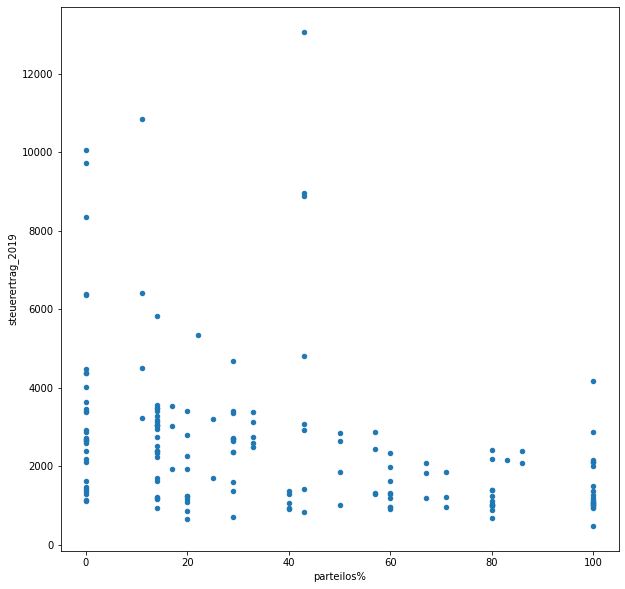

In [8]:
df.plot.scatter(x='parteilos%', y='steuerertrag_2019', figsize=(10, 10))

## Wo FDP Mehrheit hat

<AxesSubplot:xlabel='topparty'>

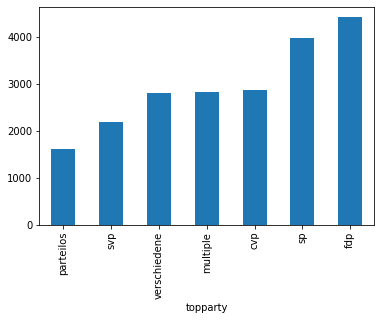

In [9]:
# Group Party/Steuerertrag
g = df.groupby('topparty').agg({'steuerertrag_2019': 'mean', 'Gemeinde': 'count'}).sort_values('steuerertrag_2019')
g['steuerertrag_2019'].plot.bar()



In [13]:
g['steuerertrag_2019'] = round(g['steuerertrag_2019'], 0)
g.sort_values('steuerertrag_2019', ascending=False)

,steuerertrag_2019,Gemeinde
topparty,,
fdp,4408.0,27
sp,3964.0,4
cvp,2862.0,1
multiple,2823.0,45
verschiedene,2794.0,4
svp,2179.0,19
parteilos,1603.0,62


## Wieviel Steuerertrag jede Partei vertritt. 1 Gemeinderat = gesamter Ertrag der Gemeinde

In [76]:
parties = ['parteilos', 'fdp', 'evp', 'svp', 'sp', 'cvp', 'glp', 'grüne', 'bdp', 'al', 'edu']

# Add Steuern to df
df = df_raw.copy()

# Add BFS
df = cd.add_bfs(df)

# Join Steuerdaten
df = df.merge(df_steuern, how='left', on='bfs')

records = []

for p in parties:
    x = df[df.partei_c == p].groupby('Gemeinde').agg({'steuerertrag_2019': 'first'})
    records.append({'party': p, 'steuerertrag_2019': round(x['steuerertrag_2019'].mean())})
    
df = pd.DataFrame(records).set_index('party').sort_values('steuerertrag_2019')

<AxesSubplot:xlabel='party'>

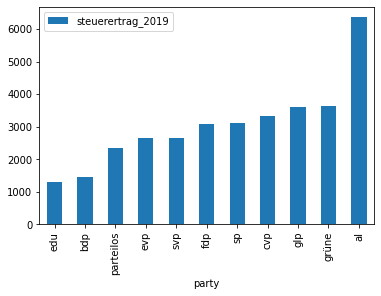

In [77]:
df.plot.bar()